In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

fatal: destination path 'LightGBM' already exists and is not an empty directory.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory:

In [ ]:
!pip install catboost

import lightgbm as lgb
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer,QuantileTransformer ,LabelEncoder, OneHotEncoder, MinMaxScaler, RobustScaler
import seaborn as sns
! pip install prince
import prince

! pip install optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
path = '/content/drive/Shareddrives/dacon/Playground/'
train = pd.read_csv(path + 'train.csv', index_col=['id'])
test = pd.read_csv(path + 'test.csv', index_col=['id'])
submission = pd.read_csv(path + 'sample_submission.csv', index_col=['id'])

train = train[(train['target'] >= 4) & (train['target'] <= 10)]

train_data = train.iloc[:,:-1]
train_target = train.iloc[:, -1]
test_data = test.copy()

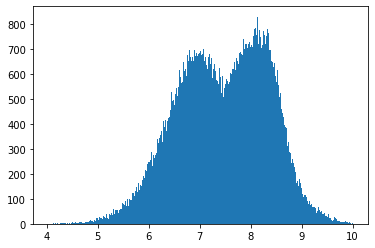

In [ ]:
plt.hist(train['target'], bins = 1000)
plt.show()

In [ ]:
cat_features = [feature for feature in train_data.columns if 'cat' in feature]
cont_features = [feature for feature in train_data.columns if 'cont' in feature]
for feature in cat_features:
    train_data[feature] = train_data[feature].astype('category')
    test_data[feature] = test_data[feature].astype('category')

In [ ]:
scaler = QuantileTransformer(random_state=42, n_quantiles=1500)

In [ ]:
a = pd.get_dummies(train_data[cat_features])
b = pd.get_dummies(test_data[cat_features])

missing_cols = set(a.columns) - set(b.columns)
for c in missing_cols:
  b[c] = 0
b = b[a.columns]

train_temp = train_data.loc[:, 'cont0' :]
test_temp = test_data.loc[:, 'cont0' :]
train_sc = scaler.fit_transform(train_temp)
test_sc = scaler.transform(test_temp)

train_scaled = pd.DataFrame(train_sc, index = train_temp.index, columns = train_temp.columns)
test_scaled = pd.DataFrame(test_sc, index = test_temp.index, columns = test_temp.columns)

trainset = pd.concat([train_scaled, a], axis = 1)
testset = pd.concat([test_scaled, b], axis = 1)

trainset

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cat0_A,cat0_B,cat1_A,cat1_B,cat2_A,cat2_B,cat3_A,cat3_B,cat3_C,cat3_D,cat4_A,cat4_B,cat4_C,cat4_D,cat5_A,cat5_B,cat5_C,cat5_D,cat6_A,cat6_B,cat6_C,cat6_D,cat6_E,cat6_G,cat6_H,cat6_I,cat7_A,cat7_B,cat7_C,cat7_D,cat7_E,cat7_F,cat7_G,cat7_I,cat8_A,cat8_B,cat8_C,cat8_D,cat8_E,cat8_F,cat8_G,cat9_A,cat9_B,cat9_C,cat9_D,cat9_E,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.941896,0.745236,0.045577,0.262730,0.347760,0.900031,0.531460,0.895006,0.932277,0.843030,0.860382,0.676361,0.944700,0.721654,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.309364,0.014759,0.343543,0.973984,0.378049,0.496356,0.272051,0.254190,0.781927,0.588822,0.672115,0.801246,0.220228,0.921688,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0.829599,0.896423,0.495255,0.935662,0.409841,0.939710,0.360150,0.943927,0.888991,0.925122,0.142695,0.654108,0.931004,0.977702,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.805847,0.938458,0.080442,0.770735,0.894348,0.961895,0.724301,0.541235,0.891994,0.815335,0.481555,0.662637,0.846013,0.581211,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0.467647,0.626618,0.600596,0.449164,0.189025,0.361712,0.835725,0.414723,0.547230,0.471861,0.860469,0.615761,0.317222,0.274759,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,0.058789,0.782277,0.090801,0.587681,0.892168,0.178857,0.063506,0.505720,0.221702,0.202577,0.102527,0.374098,0.006394,0.871526,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
499996,0.019670,0.125125,0.796398,0.157489,0.902538,0.027097,0.061107,0.686753,0.112025,0.158524,0.173042,0.264397,0.132846,0.104963,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
499997,0.203828,0.550793,0.515542,0.559584,0.414715,0.519125,0.421687,0.596585,0.045958,0.518089,0.102635,0.249700,0.017691,0.369397,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
lgb_params = {}
folds = 10


lgb_params['random_state'] = 42
lgb_params['device'] = 'gpu'
lgb_params['learning_rate'] = 0.001
lgb_params['max_bin'] = 36
lgb_params['n_estimators'] = 80000
lgb_params['feature_fraction'] = 0.939633272982788
lgb_params['subsample'] = 0.7594425005365053
lgb_params['num_leaves'] = 221
lgb_params['min_data'] = 76
lgb_params['max_depth'] = 19
lgb_params['boosting_type'] = 'goss'
lgb_params['min_child_weight'] = 0.0009160485516886867
lgb_params['max_drop'] = 77

lgbm_rg = lgb.LGBMRegressor(**lgb_params)

In [ ]:
cat_params = {}

cat_params['random_state'] = 42
cat_params['iterations'] = 80000
cat_params['subsample'] = 0.9965285997680801
cat_params['max_depth'] = 10
cat_params['l2_leaf_reg'] = 0.5925500443911146
cat_params['objective'] = 'RMSE'
cat_params['bootstrap_type'] = 'Bernoulli'
cat_params['min_data_in_leaf'] = 95
cat_params['task_type'] = 'GPU'
cat_params['max_bin'] = 36
cat_params['learning_rate'] = 0.001
# cat_params['cat_features'] = cat_features

cat_rg = catboost.CatBoostRegressor(**cat_params)

In [ ]:
xgb_params = {}

xgb_params['n_estimators'] = 5000
xgb_params['max_depth'] = 16
xgb_params['min_child_weight'] = 1
xgb_params['gamma'] = 3
xgb_params['learning_rate'] = 0.01
xgb_params['colsample_bytree'] = 0.7
xgb_params['nthred'] = -1
xgb_params['tree_method'] = 'gpu_hist'
xgb_params['gpu_id'] = 0
xgb_params['lambda'] = 0.0010427076152342994
xgb_params['alpha'] = 1.3661217689723608
xgb_params['subsample'] = 0.95
xgb_params['random_state'] = 42

xgb_rg = XGBRegressor(**xgb_params)

In [ ]:
X_train, X_valid, Y_train,  Y_valid = train_test_split(trainset, train_target, test_size=0.20, random_state=42)

In [ ]:
# ## trains

# print('LGBM')
# lgbm_rg.fit(X_train, Y_train, eval_metric = ['RMSE'], eval_set=[(X_valid, Y_valid)], early_stopping_rounds=500, verbose=False)

# print("CAT")
# cat_rg.fit(X_train, Y_train,eval_set=[(X_valid, Y_valid)], early_stopping_rounds=500, verbose=False)

# print("XGB")
# xgb_rg.fit(X_train, Y_train,eval_set=[(X_valid, Y_valid)], early_stopping_rounds=500, verbose=False)

In [ ]:
# lgbm_pred = lgbm_rg.predict(testset)
# cat_pred = cat_rg.predict(testset)
# xgb_pred = xgb_rg.predict(testset)

In [ ]:
submission_lgbm = submission.copy()
submission_cat = submission.copy()
submission_xgb = submission.copy()

In [ ]:
# submission_lgbm['target'] = lgbm_pred
# submission_cat['target'] = cat_pred
# submission_xgb['target'] = xgb_pred

In [ ]:
# submission_mean = (submission_lgbm + submission_cat + submission_xgb)/3
# submission_lgbm_f = 0.2 * submission_lgbm + 0.4 *submission_cat + 0.4 *submission_xgb
# submission_cat_f = 0.4 * submission_lgbm + 0.2 *submission_cat + 0.4 *submission_xgb
# submission_xgb_f = 0.4 * submission_lgbm + 0.4 *submission_cat + 0.2 *submission_xgb

In [ ]:
# submission_mean.to_csv("submission_mean.csv", index = True)
# !cp submission_mean.csv "drive/My Drive/"
# submission_lgbm_f.to_csv("submission_lgbm_f.csv", index = True)
# !cp submission_lgbm_f.csv "drive/My Drive/"
# submission_cat_f.to_csv("submission_cat_f.csv", index = True)
# !cp submission_cat_f.csv "drive/My Drive/"
# submission_xgb_f.to_csv("submission_xgb_f.csv", index = True)
# !cp submission_xgb_f.csv "drive/My Drive/"

In [ ]:
# submission_xgb.to_csv("submission_xgb.csv", index = True)
# !cp submission_xgb.csv "drive/My Drive/"

In [ ]:
def create_stratified_folds_for_regression(data_df, data_target, n_splits=folds):
    """
    @param data_df: training data to split in Stratified K Folds for a continous target value
    @param n_splits: number of splits
    @return: the training data with a column with kfold id
    """
    data_df = pd.concat([data_df, data_target], axis = 1)
    data_df['kfold'] = -1
    # randomize the data
    data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)
    # calculate the optimal number of bins based on log2(data_df.shape[0])
    num_bins = np.int(np.floor(1 + np.log2(len(data_df))))
    # bins value will be the equivalent of class value of target feature used by StratifiedKFold to 
    # distribute evenly the classed over each fold
    data_df.loc[:, "bins"] = pd.cut(pd.to_numeric(data_df['target'], downcast="signed"), bins=num_bins, labels=False)
    kf = StratifiedKFold(n_splits=n_splits, random_state=42)
    
    # set the fold id as a new column in the train data
    for f, (t_, v_) in enumerate(kf.split(X=data_df, y=data_df.bins.values)):
        data_df.loc[v_, 'kfold'] = f
    
    # drop the bins column (no longer needed)
    data_df = data_df.drop("bins", axis=1)
    
    return data_df

In [ ]:
def cv_evaluation_regression(df, test, model):
    n_fold = folds
    oof = np.zeros((len(df),))
    subs = np.zeros((len(test),))
    for fold in tqdm(range(n_fold)):
        val_ind = df[df.kfold == fold].index
        train = df[df.kfold != fold].reset_index(drop=True)
        valid = df[df.kfold == fold].reset_index(drop=True)

        features = [feature for feature in df.columns if feature not in ['id', 'target', 'kfold']]

        X_train = train[features]
        y_train = train['target']
        X_valid = valid[features]
        y_valid = valid['target']
        print('a')
        model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 800, verbose=500)
        preds = model.predict(valid[features])
        mse = mean_squared_error(y_valid, preds)
        print('b')

        oof[val_ind] = preds
        print('c')
        sub = model.predict(test[features])
        subs += sub
        print('d')
    mse_oof = mean_squared_error(oof, df['target'])
    
    print(f'Model Overall RMSE:{np.sqrt(mse_oof)}')
    return np.sqrt(mse_oof), subs/folds

In [ ]:
train_cv = create_stratified_folds_for_regression(trainset, train_target)
lgbm_rg = lgb.LGBMRegressor(**lgb_params)
cat_rg = catboost.CatBoostRegressor(**cat_params)

In [ ]:
lgbm_score, lgbm_result = cv_evaluation_regression(train_cv, testset, lgbm_rg)

print("LGBM score is {0}".format(lgbm_score))

submission_lgbm = submission.copy()
submission_lgbm['target'] = lgbm_result
submission_lgbm.to_csv("lgbm_10fold.csv", index = True)
!cp lgbm_10fold.csv "drive/My Drive/"

a
Training until validation scores don't improve for 800 rounds
[500]	valid_0's l2: 0.755415
[1000]	valid_0's l2: 0.741519
[1500]	valid_0's l2: 0.732612
[2000]	valid_0's l2: 0.726934
[2500]	valid_0's l2: 0.723076
[3000]	valid_0's l2: 0.720358
[3500]	valid_0's l2: 0.7184
[4000]	valid_0's l2: 0.716875
[4500]	valid_0's l2: 0.715741
[5000]	valid_0's l2: 0.714928
[5500]	valid_0's l2: 0.714198
[6000]	valid_0's l2: 0.713616
[6500]	valid_0's l2: 0.713214
[7000]	valid_0's l2: 0.712939
[7500]	valid_0's l2: 0.712697
[8000]	valid_0's l2: 0.71249
[8500]	valid_0's l2: 0.712327
[9000]	valid_0's l2: 0.712168
[9500]	valid_0's l2: 0.712053
[10000]	valid_0's l2: 0.712018
[10500]	valid_0's l2: 0.711957
[11000]	valid_0's l2: 0.711934
[11500]	valid_0's l2: 0.71193
[12000]	valid_0's l2: 0.711916
Early stopping, best iteration is:
[11624]	valid_0's l2: 0.711907
b
c
d
a
[LightGBM] [Warning] min_data_in_leaf is set with min_data=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[Light

In [ ]:
cat_score, cat_result = cv_evaluation_regression(train_cv, testset, cat_rg)

submission_cat = submission.copy()
submission_cat['target'] = cat_result
print("CAT score is {0}".format(cat_score))

submission_cat.to_csv("cat_10fold.csv", index = True)
!cp cat_10fold.csv "drive/My Drive/"

a
0:	learn: 0.8854989	test: 0.8859563	best: 0.8859563 (0)	total: 10.9ms	remaining: 14m 30s
500:	learn: 0.8701848	test: 0.8719633	best: 0.8719633 (500)	total: 4.59s	remaining: 12m 8s
1000:	learn: 0.8622334	test: 0.8649822	best: 0.8649822 (1000)	total: 9.12s	remaining: 12m
1500:	learn: 0.8573926	test: 0.8609492	best: 0.8609492 (1500)	total: 13.6s	remaining: 11m 52s
2000:	learn: 0.8540256	test: 0.8582544	best: 0.8582544 (2000)	total: 18.2s	remaining: 11m 48s
2500:	learn: 0.8514400	test: 0.8562927	best: 0.8562927 (2500)	total: 22.7s	remaining: 11m 42s
3000:	learn: 0.8493282	test: 0.8547981	best: 0.8547981 (3000)	total: 27.2s	remaining: 11m 37s
3500:	learn: 0.8475346	test: 0.8536323	best: 0.8536323 (3500)	total: 31.8s	remaining: 11m 35s
4000:	learn: 0.8459474	test: 0.8526940	best: 0.8526940 (4000)	total: 36.4s	remaining: 11m 31s
4500:	learn: 0.8445092	test: 0.8519226	best: 0.8519226 (4500)	total: 41.1s	remaining: 11m 28s
5000:	learn: 0.8431972	test: 0.8512648	best: 0.8512648 (5000)	total: 4

In [ ]:
xgb_rg = XGBRegressor(**xgb_params)
xgb_score = cv_evaluation_regression(train_cv, xgb_rg)
print(xgb_score)

[10:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

LGBM Overall RMSE:0.8468796004406677
0.8468796004406677


In [ ]:
submission_xgb = submission.copy()

In [ ]:
submission_xgb['target'] = (cat_result + lgbm_result)/2
submission_xgb

,target
id,
0,7.713856
5,7.913148
15,7.648233
16,7.414570
17,7.291667
...,...
499987,7.476053
499990,7.239391
499991,7.532962


In [ ]:
submission_xgb.to_csv("ensemble_half_lg_cat.csv", index = True)
!cp ensemble_half_lg_cat.csv "drive/My Drive/"

In [ ]:
submission_cat.to_csv("cat_10fold.csv", index = True)
!cp cat_10fold.csv "drive/My Drive/"